# 워드 임베딩(Word Embedding)

## 1) 영어/한국어 Word2Vec 실습

이번 챕터에서는 영어와 한국어 훈련 데이터에 대해서 Word2Vec을 학습해보겠습니다. gensim 패키지에서 Word2Vec은 이미 구현되어져 있으므로, 별도로 Word2Vec을 구현할 필요없이 손쉽게 훈련시킬 수 있습니다.

### 1. 영어 Word2Vec 만들기

이번에는 영어 데이터를 다운로드 받아 직접 Word2Vec 작업을 진행해보겠습니다. 파이썬의 gensim 패키지에는 Word2Vec을 지원하고 있어, gensim 패키지를 이용하면 손쉽게 단어를 임베딩 벡터로 변환시킬 수 있습니다. 영어로 된 코퍼스를 다운받아 전처리를 수행하고, 전처리한 데이터를 바탕으로 Word2Vec 작업을 진행하겠습니다.

#### 1) 훈련 데이터 이해하기

링크 : https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip

위 링크에서 훈련 데이터를 다운로드 받을 수 있습니다. 위 zip 파일의 압축을 풀면 ted_en-20160408.xml이라는 파일이 있는데, 이를 훈련 데이터로 사용할 예정입니다.

아래는 해당 xml 파일의 형식을 보여줍니다.

#### 2) 데이터 로드 및 전처리하기

데이터를 다운로드하고, xml 파일로부터 필요한 내용만을 가져와 저장합니다.

In [1]:
import re
from lxml import etree
import urllib.request
import zipfile
from nltk.tokenize import word_tokenize, sent_tokenize

urllib.request.urlretrieve("https://wit3.fbk.eu/get.php?path=XML_releases/xml/ted_en-20160408.zip&filename=ted_en-20160408.zip", filename="ted_en-20160408.zip")
# 데이터 다운로드

with zipfile.ZipFile('ted_en-20160408.zip', 'r') as z:
  target_text = etree.parse(z.open('ted_en-20160408.xml', 'r'))
  parse_text = '\n'.join(target_text.xpath('//content/text()'))
# xml 파일로부터 <content>와 </content> 사이의 내용만 가져온다.

로드한 데이터 중에서 300개의 글자(characters)만 출력해보겠습니다.

In [2]:
print(len(parse_text))
parse_text[:300]

24222849


"Here are two reasons companies fail: they only do more of the same, or they only do what's new.\nTo me the real, real solution to quality growth is figuring out the balance between two activities: exploration and exploitation. Both are necessary, but it can be too much of a good thing.\nConsider Facit"

전처리를 수행합니다.

In [3]:
content_text = re.sub(r'\([^)]*\)', '', parse_text) # (hello) () 
# 정규 표현식의 sub 모듈을 통해 content 중간에 등장하는 (Audio), (Laughter) 등의 배경음 부분을 제거.
# 해당 코드는 괄호로 구성된 내용을 제거.

sent_text=sent_tokenize(content_text)
# 입력 코퍼스에 대해서 NLTK를 이용하여 문장 토큰화를 수행.

normalized_text = []
for string in sent_text:
     tokens = re.sub(r"[^a-z0-9]+", " ", string.lower())
     normalized_text.append(tokens)
# 각 문장에 대해서 구두점을 제거하고, 대문자를 소문자로 변환.

result = [word_tokenize(sentence) for sentence in normalized_text]
# 각 문장에 대해서 NLTK를 이용하여 단어 토큰화를 수행.

전처리 수행 후의 총 샘플의 개수는 몇 개일까요?

In [4]:
print('총 샘플의 개수 : {}'.format(len(result)))

총 샘플의 개수 : 273424


총 샘플의 개수는 약 27만 3천개입니다.

In [5]:
print(result[:2])
for line in result[:3]: # 샘플 3개만 출력
    print(line)

[['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new'], ['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']]
['here', 'are', 'two', 'reasons', 'companies', 'fail', 'they', 'only', 'do', 'more', 'of', 'the', 'same', 'or', 'they', 'only', 'do', 'what', 's', 'new']
['to', 'me', 'the', 'real', 'real', 'solution', 'to', 'quality', 'growth', 'is', 'figuring', 'out', 'the', 'balance', 'between', 'two', 'activities', 'exploration', 'and', 'exploitation']
['both', 'are', 'necessary', 'but', 'it', 'can', 'be', 'too', 'much', 'of', 'a', 'good', 'thing']


상위 3개 문장만 출력해보았는데 토큰화가 수행되었음을 볼 수 있습니다. 이제 Word2Vec 모델에 텍스트 데이터를 훈련시킵니다.

3) Word2Vec 훈련시키기

In [6]:
!pip install gensim

  Created wheel for smart-open: filename=smart_open-3.0.0-py3-none-any.whl size=107102 sha256=725821703d0d262a7950689796499468ad64095408e39fd34287b3b205b64ccd
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\11\73\9a\f91ac1f1816436b16423617c5be5db048697ff152a9c4346f2
Successfully built smart-open
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21


In [7]:
from gensim.models import Word2Vec
model = Word2Vec(sentences=result, size=100, window=5, min_count=5, workers=4, sg=0)

여기서 Word2Vec의 하이퍼파라미터값은 다음과 같습니다.
size = 워드 벡터의 특징 값. 즉, 임베딩 된 벡터의 차원.
window = 컨텍스트 윈도우 크기
min_count = 단어 최소 빈도 수 제한 (빈도가 적은 단어들은 학습하지 않는다.)
workers = 학습을 위한 프로세스 수
sg = 0은 CBOW, 1은 Skip-gram.

이제 Word2Vec에 대해서 학습을 진행하였습니다. Word2Vec는 입력한 단어에 대해서 가장 유사한 단어들을 출력하는 model.wv.most_similar을 지원합니다. man과 가장 유사한 단어들은 어떤 단어들일까요?

In [14]:
model_result = model.wv.most_similar("man")
print(model_result)

[('woman', 0.8430303335189819), ('guy', 0.7995673418045044), ('lady', 0.7713043689727783), ('boy', 0.7505444288253784), ('gentleman', 0.7413794994354248), ('girl', 0.7359131574630737), ('soldier', 0.7012191414833069), ('kid', 0.6932430267333984), ('poet', 0.6773760318756104), ('philosopher', 0.6686331033706665)]


man과 유사한 단어로 woman, guy, boy, lady, girl, gentleman, soldier, kid 등을 출력하는 것을 볼 수 있습니다. 이제 Word2Vec를 통해 단어의 유사도를 계산할 수 있게 되었습니다.

#### 4) Word2Vec 모델 저장하고 로드하기

공들여 학습한 모델을 언제든 나중에 다시 사용할 수 있도록 컴퓨터 파일로 저장하고 다시 로드해보겠습니다. 이 모델을 가지고 시각화 챕터에서 시각화를 진행할 예정이므로 꼭 저장해주세요.

In [8]:
from gensim.models import KeyedVectors
model.wv.save_word2vec_format('eng_w2v') # 모델 저장
loaded_model = KeyedVectors.load_word2vec_format("eng_w2v") # 모델 로드

로드한 모델에 대해서 다시 man과 유사한 단어를 출력해보겠습니다.

In [9]:
model_result = loaded_model.most_similar("man")
print(model_result)

[('woman', 0.8462902307510376), ('guy', 0.8202043771743774), ('lady', 0.7939596176147461), ('soldier', 0.7463676929473877), ('boy', 0.7434981465339661), ('gentleman', 0.739277720451355), ('girl', 0.7316141128540039), ('kid', 0.7195367217063904), ('poet', 0.694628894329071), ('friend', 0.6559626460075378)]


#### 2. 한국어 Word2Vec 만들기(네이버 영화 리뷰)

In [10]:
import urllib.request
from konlpy.tag import Okt
from gensim.models.word2vec import Word2Vec
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x1a7fe9f3490>)

In [12]:
train_data = pd.read_table('ratings.txt')

In [13]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [14]:
print(len(train_data)) # 리뷰 개수 출력

200000


In [15]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [16]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [17]:
print(len(train_data)) # 리뷰 개수 출력

199992


In [18]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [20]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


In [21]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [22]:
# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


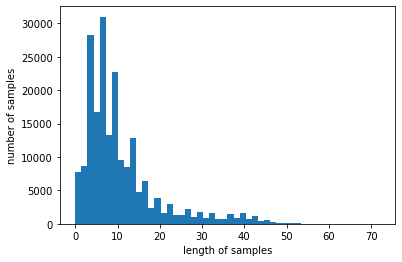

In [24]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [25]:
from gensim.models import Word2Vec
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [26]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(16477, 100)

In [27]:
print(model.wv.most_similar("최민식"))

[('안성기', 0.8771382570266724), ('한석규', 0.8673361539840698), ('박중훈', 0.8620112538337708), ('이정재', 0.8618786931037903), ('송강호', 0.8559349179267883), ('김명민', 0.8493683338165283), ('이민호', 0.8471220135688782), ('설경구', 0.8471061587333679), ('유다인', 0.8458004593849182), ('황정민', 0.8426992297172546)]


In [29]:
print(model.wv.most_similar("공포"))

[('스릴러', 0.8263371586799622), ('코미디', 0.7168378829956055), ('장르', 0.7054276466369629), ('공포영화', 0.6875077486038208), ('멜로', 0.686943531036377), ('공포물', 0.6729100942611694), ('좀비', 0.6690431833267212), ('미스터리', 0.6598478555679321), ('코믹', 0.6503236889839172), ('서스펜스', 0.6493826508522034)]


### 3. 한국어 Word2Vec 만들기(위키피디아)

이번에는 위키피디아 한국어 덤프 파일을 다운받아서 한국어로 Word2Vec을 직접 진행해보겠습니다. 영어와 크게 다른 점은 없지만 한국어는 형태소 토큰화를 해야만 좋은 성능을 얻을 수 있습니다. 간단히 말해 형태소 분석기를 사용합니다.

#### 1) 위키피디아 한국어 덤프 파일 다운로드

https://dumps.wikimedia.org/kowiki/latest/

위 링크에는 많은 위키피디아 덤프 파일들이 존재합니다. 그 중에서 사용할 데이터는 kowiki-latest-pages-articles.xml.bz2 파일입니다. 해당 파일은 xml 파일므로, Word2Vec을 원활하게 진행하기 위해 파일 형식을 변환해줄 필요가 있습니다.

#### 2) 위키피디아 익스트랙터 다운로드

해당 파일을 모두 다운로드 받았다면 위키피디아 덤프 파일을 텍스트 형식으로 변환시켜주는 오픈소스인 '위키피디아 익스트랙터'를 사용할 것입니다. '위키피디아 익스트랙터'를 다운로드 받기 위해서는 윈도우의 명령 프롬프트나 MAC과 리눅스의 터미널에서 아래의 git clone 명령어를 통해 다운로드 받을 수 있습니다.

In [30]:
!pip install wikiextractor

  Created wheel for wikiextractor: filename=wikiextractor-0.1-py3-none-any.whl size=38824 sha256=8aa7bdc955e48c69704b15811946583daba13455a9ef50a21f5c886ff6e55f3a
  Stored in directory: c:\users\user\appdata\local\pip\cache\wheels\98\50\4b\5a06f4f998b52f6b828af95aa4e1b3efb784b3210c970bcaf3
Successfully built wikiextractor


#### 3) 위키피디아 한국어 덤프 파일 변환

위키피디아 익스트랙터와 위키피디아 한국어 덤프 파일을 동일한 디렉토리 경로에 두고, 아래 명령어를 실행하면 위키피디아 덤프 파일이 텍스트 파일로 변환됩니다. 컴퓨터마다 다르지만 보통 10분 내외의 시간이 걸립니다.

python -m wikiextractor.WikiExtractor kowiki-latest-pages-articles.xml.bz2 

텍스트 파일로 변환된 위키피디아 한국어 덤프는 총 6개의 디렉토리(2018년 10월 기준)로 구성되어져 있습니다. AA ~ AF의 디렉토리로 각 디렉토리 내에는 wiki_00 ~ wiki_90이라는 파일들이 들어있습니다. 각 파일들을 열어보면 이와 같은 구성이 반복되고 있습니다.

예를 들어서 AA 디렉토리의 wiki_00 파일을 읽어보면, 지미 카터에 대한 내용이 나옵니다.

이제 이 6개 AA ~ AF 디렉토리 안의 wiki00 ~ wiki90 파일들을 하나의 텍스트 파일로 통합하겠습니다. (만약, 더 간단히 하고 싶다면 모든 디렉토리 파일을 통합하지 않고, 하나의 디렉토리 내의 파일들에 대해서만 통합 작업을 진행하고 모델의 입력으로 사용할수도있습니다. 하지만 모델의 성능은 전체 파일에 대해서 진행한 경우보다 좋지 않을 수 있습니다.)

작업은 6개의 디렉토리 내 파일들에 대해서 각 하나의 파일로 통합 후, 6개의 파일을 다시 하나로 통합하는 순서로 진행합니다.

#### 4) 훈련 데이터 만들기

우선 AA 디렉토리 안의 모든 파일인 wiki00 ~ wiki90에 대해서 wikiAA.txt로 통합해보겠습니다. 프롬프트에서 아래의 커맨드를 수행합니다. (윈도우 환경 기준)

copy .\text\AA\*.* wiki_AA.txt

해당 커맨드는 AA디렉토리 안의 wiki로 시작되는 모든 파일을 wikiAA.txt 파일에 전부 복사하라는 의미를 담고있습니다. 결과적으로 wiki00 ~ wiki90파일의 모든 내용은 wikiAA.txt 파일이라는 하나의 파일에 내용이 들어가게 됩니다.

각 디렉토리에 대해서도 동일하게 진행합니다.

copy .\text\AB\*.* wiki_AB.txt  
copy .\text\AC\*.* wiki_AC.txt 
copy .\text\AD\*.* wiki_AD.txt  
copy .\text\AE\*.* wiki_AE.txt 
copy .\text\AF\*.* wiki_AF.txt

이렇게 되면 현재 경로에는 각 디렉토리의 파일들을 하나로 합친 wikiAA.txt 부터 wikiAF.txt라는 6개의 파일이 생깁니다. 그럼 이제 이 파일들에 대해서도 하나의 파일로 합치는 작업을 진행해보겠습니다.

copy wiki*.txt wiki_data.txt

이제 모든 텍스트 파일을 하나로 만든 훈련 데이터가 완성되었습니다.

#### 5) 훈련 데이터 전처리 하기

In [31]:
f = open('wiki_data.txt', encoding="utf8")
# 예를 들어 위도우 바탕화면에서 작업한 저자의 경우
# f = open(r'C:\Users\USER\Desktop\wiki_data.txt', encoding="utf8")

우선 파일을 불러왔습니다. 파일이 정상적으로 저장되었는지 5개의 줄만 출력해보겠습니다.

In [32]:
i=0
while True:
    line = f.readline()
    if line != '\n':
        i=i+1
        print("%d번째 줄 :"%i + line)
    if i==5:
        break 
f.close()

1번째 줄 :<doc id="5" url="https://ko.wikipedia.org/wiki?curid=5" title="지미 카터">

2번째 줄 :지미 카터

3번째 줄 :제임스 얼 "지미" 카터 주니어(, 1924년 10월 1일 ~ )는 민주당 출신 미국 39번째 대통령 (1977년 ~ 1981년)이다.

4번째 줄 :지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다. 조지아 공과대학교를 졸업하였다. 그 후 해군에 들어가 전함·원자력·잠수함의 승무원으로 일하였다. 1953년 미국 해군 대위로 예편하였고 이후 땅콩·면화 등을 가꿔 많은 돈을 벌었다. 그의 별명이 "땅콩 농부" (Peanut Farmer)로 알려졌다.

5번째 줄 :1962년 조지아 주 상원 의원 선거에서 낙선하나 그 선거가 부정선거 였음을 입증하게 되어 당선되고, 1966년 조지아 주 지사 선거에 낙선하지만 1970년 조지아 주 지사를 역임했다. 대통령이 되기 전 조지아주 상원의원을 두번 연임했으며, 1971년부터 1975년까지 조지아 지사로 근무했다. 조지아 주지사로 지내면서, 미국에 사는 흑인 등용법을 내세웠다.



정상적으로 출력되는 것을 볼 수 있습니다. 이제 본격적으로 Word2Vec을 위한 학습 데이터를 만들어보겠습니다.

In [33]:
from konlpy.tag import Okt  
okt=Okt()
fread = open('wiki_data.txt', encoding="utf8")
# 파일을 다시 처음부터 읽음.
n=0
result = []

while True:
    line = fread.readline() #한 줄씩 읽음.
    if not line: break # 모두 읽으면 while문 종료.
    n=n+1
    if n%5000==0: # 5,000의 배수로 While문이 실행될 때마다 몇 번째 While문 실행인지 출력.
        print("%d번째 While문."%n)
    tokenlist = okt.pos(line, stem=True, norm=True) # 단어 토큰화
    temp=[]
    for word in tokenlist:
        if word[1] in ["Noun"]: # 명사일 때만
            temp.append((word[0])) # 해당 단어를 저장함

    if temp: # 만약 이번에 읽은 데이터에 명사가 존재할 경우에만
      result.append(temp) # 결과에 저장
fread.close()

5000번째 While문.
10000번째 While문.
15000번째 While문.
20000번째 While문.
25000번째 While문.
30000번째 While문.
35000번째 While문.
40000번째 While문.
45000번째 While문.
50000번째 While문.
55000번째 While문.
60000번째 While문.
65000번째 While문.
70000번째 While문.
75000번째 While문.
80000번째 While문.
85000번째 While문.
90000번째 While문.
95000번째 While문.
100000번째 While문.
105000번째 While문.
110000번째 While문.
115000번째 While문.
120000번째 While문.
125000번째 While문.
130000번째 While문.
135000번째 While문.
140000번째 While문.
145000번째 While문.
150000번째 While문.
155000번째 While문.
160000번째 While문.
165000번째 While문.
170000번째 While문.
175000번째 While문.
180000번째 While문.
185000번째 While문.
190000번째 While문.
195000번째 While문.
200000번째 While문.
205000번째 While문.
210000번째 While문.
215000번째 While문.
220000번째 While문.
225000번째 While문.
230000번째 While문.
235000번째 While문.
240000번째 While문.
245000번째 While문.
250000번째 While문.
255000번째 While문.
260000번째 While문.


KeyboardInterrupt: 

여기서는 형태소 분석기로 KoNLPy의 Okt를 사용하여 명사만을 추출하여 훈련 데이터를 구성하겠습니다. 위 작업은 시간이 꽤 걸립니다. 훈련 데이터를 모두 만들었다면, 훈련 데이터의 길이를 확인해보겠습니다.

In [5]:
print('총 샘플의 개수 : {}'.format(len(result))

SyntaxError: unexpected EOF while parsing (<ipython-input-5-791a3cf29425>, line 1)

약 240만여개의 줄(line)이 명사 토큰화가 되어 저장되어 있는 상태입니다. 이제 이를 Word2Vec으로 학습시킵니다.

#### 6) Word2Vec 훈련시키기

In [6]:
from gensim.models import Word2Vec
model = Word2Vec(result, size=100, window=5, min_count=5, workers=4, sg=0)

학습을 다했다면 이제 임의의 입력 단어로부터 유사한 단어들을 구해봅시다.

In [7]:
model_result1 = model.wv.most_similar("대한민국")
print(model_result1)

[('한국', 0.6791932582855225), ('조선민주주의인민공화국', 0.5612313747406006), ('우리나라', 0.5568702220916748), ('부산광역시', 0.5173649191856384), ('관세청', 0.49443531036376953), ('재일동포', 0.49121564626693726), ('대구광역시', 0.48996126651763916), ('지식경제부', 0.4863876700401306), ('방위사업청', 0.48310595750808716), ('대전광역시', 0.4814496636390686)]


In [14]:
model_result2 = model.wv.most_similar("홍상수")
print(model_result2)

[('김지운', 0.8606835007667542), ('왕가위', 0.8571169376373291), ('허진호', 0.8384286165237427), ('김대승', 0.8354521989822388), ('임상수', 0.8257595300674438), ('이정범', 0.8235232830047607), ('봉준호', 0.822992205619812), ('오우삼', 0.8184781074523926), ('이장호', 0.8165385127067566), ('최동훈', 0.8163712024688721)]


In [9]:
model_result3 = model.wv.most_similar("반도체")
print(model_result3)

[('집적회로', 0.8066496253013611), ('실리콘', 0.8011645078659058), ('전자부품', 0.7966008186340332), ('태양전지', 0.7711134552955627), ('팹리스', 0.7657057642936707), ('페어차일드', 0.7538235187530518), ('웨이퍼', 0.7524611949920654), ('트랜지스터', 0.7400067448616028), ('전자제품', 0.7391147613525391), ('박막', 0.7331544160842896)]


### 3. 사전 훈련된 Word2Vec 임베딩(Pre-trained Word2Vec embedding) 소개

자연어 처리 작업을 할때, 케라스의 Embedding()를 사용하여 갖고 있는 훈련 데이터로부터 처음부터 임베딩 벡터를 훈련시키기도 하지만, 위키피디아 등의 방대한 데이터로 사전에 훈련된 워드 임베딩(pre-trained word embedding vector)를 가지고 와서 해당 벡터들의 값을 원하는 작업에 사용 할 수도 있습니다.

예를 들어서 감성 분류 작업을 하는데 훈련 데이터의 양이 부족한 상황이라면, 다른 방대한 데이터를 Word2Vec이나 GloVe 등으로 사전에 학습시켜놓은 임베딩 벡터들을 가지고 와서 모델의 입력으로 사용하는 것이 때로는 더 좋은 성능을 얻을 수 있습니다.

여기서는 사전 훈련된 워드 임베딩을 가져와서 간단히 단어들의 유사도를 구해보는 실습을 해보겠습니다. 실제로 모델에 적용해보는 실습은 사전 훈련된 워드 임베딩 챕터에서 진행합니다.

#### 1) 영어

이번에는 구글이 제공하는 사전 훈련된(미리 학습되어져 있는) Word2Vec 모델을 사용하는 방법에 대해서 알아보도록 하겠습니다. 구글은 사전 훈련된 3백만 개의 Word2Vec 단어 벡터들을 제공합니다. 각 임베딩 벡터의 차원은 300입니다. gensim을 통해서 이 모델을 불러오는 건 매우 간단합니다. 이 모델을 다운로드하고 파일 경로를 기재하면 됩니다.

모델 다운로드 경로 : https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

압축 파일의 용량은 약 1.5GB이지만, 파일의 압축을 풀면 약 3.3GB의 파일이 나옵니다.

In [34]:
import gensim

# 구글의 사전 훈련된 Word2Vec 모델을 로드합니다.
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

In [35]:
print(model.vectors.shape) # 모델의 크기 확인

(3000000, 300)


In [36]:
print (model.similarity('this', 'is')) # 두 단어의 유사도 계산하기
print (model.similarity('post', 'book'))

0.40797037
0.057204384


In [37]:
model_result = model.wv.most_similar("book")
print(model_result)

<ipython-input-37-3d0fa3681b27>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  model_result = model.wv.most_similar("book")


[('tome', 0.7485831379890442), ('books', 0.7379177808761597), ('memoir', 0.7302926778793335), ('paperback_edition', 0.6868364810943604), ('autobiography', 0.6741527318954468), ('memoirs', 0.6505153179168701), ('Book', 0.6479282975196838), ('paperback', 0.6471226811408997), ('novels', 0.6341458559036255), ('hardback', 0.6283079385757446)]


In [38]:
print(model['book']) # 단어 'book'의 벡터 출력

[ 0.11279297 -0.02612305 -0.04492188  0.06982422  0.140625    0.03039551
 -0.04370117  0.24511719  0.08740234 -0.05053711  0.23144531 -0.07470703
  0.21875     0.03466797 -0.14550781  0.05761719  0.00671387 -0.00701904
  0.13183594 -0.25390625  0.14355469 -0.140625   -0.03564453 -0.21289062
 -0.24804688  0.04980469 -0.09082031  0.14453125  0.05712891 -0.10400391
 -0.19628906 -0.20507812 -0.27539062  0.03063965  0.20117188  0.17382812
  0.09130859 -0.10107422  0.22851562 -0.04077148  0.02709961 -0.00106049
  0.02709961  0.34179688 -0.13183594 -0.078125    0.02197266 -0.18847656
 -0.17480469 -0.05566406 -0.20898438  0.04858398 -0.07617188 -0.15625
 -0.05419922  0.01672363 -0.02722168 -0.11132812 -0.03588867 -0.18359375
  0.28710938  0.01757812  0.02185059 -0.05664062 -0.01251221  0.01708984
 -0.21777344 -0.06787109  0.04711914 -0.00668335  0.08544922 -0.02209473
  0.31835938  0.01794434 -0.02246094 -0.03051758 -0.09570312  0.24414062
  0.20507812  0.05419922  0.29101562  0.03637695  0.04

#### 2) 한국어

한국어의 미리 학습된 Word2Vec 모델은 박규병님의 깃허브 주소인 https://github.com/Kyubyong/wordvectors 에 공개되어져 있습니다. 박규병님이 공개한 직접적인 다운로드 링크는 아래와 같습니다.

모델 다운로드 경로 : https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view

위의 링크로부터 77MB 크기의 ko.zip 파일을 다운로드 받아서 압축을 풀면 ko.bin이라는 50MB 크기의 파일이 있습니다. 이 파일을 로드하고 유사도를 계산해보겠습니다.

In [39]:
import gensim
model = gensim.models.Word2Vec.load('ko.bin')

In [41]:
result = model.wv.most_similar("고양이")
print(result)

[('토끼', 0.7924245595932007), ('원숭이', 0.7570015788078308), ('강아지', 0.7290453910827637), ('돼지', 0.7203201055526733), ('개구리', 0.7201221585273743), ('족제비', 0.7200244665145874), ('악어', 0.7142964005470276), ('멧돼지', 0.7096993923187256), ('고슴도치', 0.7051361799240112), ('거위', 0.6985242366790771)]


참고 : Word2vec 모델은 자연어 처리에서 단어를 밀집 벡터로 만들어주는 단어 임베딩 방법론이지만 최근에 들어서는 자연어 처리를 넘어서 추천 시스템에도 사용되고 있는 모델입니다. 우선 적당하게 데이터를 나열해주면 Word2vec은 위치가 근접한 데이터를 유사도가 높은 벡터를 만들어준다는 점에서 착안된 아이디어입니다.

## 4) Word2Vec 구현하기(Skip-Gram with Negative Sampling, SGNS)

### 1. 네거티브 샘플링을 사용한 Skip-Gram(Skip-Gram with Negative Sampling, SGNS)

http://jalammar.github.io/illustrated-word2vec/

### 2. 20뉴스그룹 데이터 전처리하기

In [42]:
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer

LSA 챕터에서 사용했던 20뉴스그룹 데이터를 재사용합니다. 이번 실습에서는 하나의 샘플에 최소 단어 2개는 있어야 합니다. 그래야만 중심 단어, 주변 단어의 관계가 성립하며 그렇지 않으면 샘플을 구성할 수 없어 에러가 발생합니다. 전처리 과정에서 지속적으로 이를 만족하지 않는 샘플들을 제거하겠습니다.

In [43]:
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [44]:
print('총 샘플 수 :',len(documents))

총 샘플 수 : 11314


총 샘플 수는 11,314개입니다. 전처리를 진행해봅시다. 불필요한 토큰을 제거하고, 소문자화를 통해 정규화를 진행합니다.

In [45]:
news_df = pd.DataFrame({'document':documents})
# 특수 문자 제거
news_df['clean_doc'] = news_df['document'].str.replace("[^a-zA-Z]", " ")
# 길이가 3이하인 단어는 제거 (길이가 짧은 단어 제거)
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
# 전체 단어에 대한 소문자 변환
news_df['clean_doc'] = news_df['clean_doc'].apply(lambda x: x.lower())

현재 데이터프레임에 Null 값이 있는지 확인합니다.

In [46]:
news_df.isnull().values.any()

False

Null 값이 없지만, 빈 값(empy) 유무도 확인해야 합니다. 모든 빈 값을 Null 값으로 변환하고, 다시 Null 값이 있는지 확인합니다.

In [47]:
news_df.replace("", float("NaN"), inplace=True)
news_df.isnull().values.any()

True

In [49]:
news_df.dropna(inplace=True)
print('총 샘플 수 :',len(news_df))

총 샘플 수 : 10995


샘플 수가 일부 줄어든 것을 확인할 수 있습니다. NLTK에서 정의한 불용어 리스트를 사용하여 불용어를 제거합니다.

In [50]:
# 불용어를 제거
stop_words = stopwords.words('english')
tokenized_doc = news_df['clean_doc'].apply(lambda x: x.split())
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])
tokenized_doc = tokenized_doc.to_list()

불용어를 제거하였으므로 단어의 수가 줄어들었습니다. 모든 샘플 중 단어가 1개 이하인 경우를 모두 찾아 제거하겠습니다.

In [52]:
# 단어가 1개 이하인 샘플의 인덱스를 찾아서 저장하고, 해당 샘플들은 제거.
drop_train = [index for index, sentence in enumerate(tokenized_doc) if len(sentence) <= 1]
tokenized_doc = np.delete(tokenized_doc, drop_train, axis=0)
print('총 샘플 수 :',len(tokenized_doc))

총 샘플 수 : 10940


샘플 수가 다시 줄어들었습니다. 단어 집합을 생성하고, 정수 인코딩을 진행합니다.

In [53]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tokenized_doc)

word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
encoded = tokenizer.texts_to_sequences(tokenized_doc)

상위 2개의 샘플을 출력해봅시다.

In [54]:
print(encoded[:2])

[[9, 59, 603, 207, 3278, 1495, 474, 702, 9470, 13686, 5533, 15227, 702, 442, 702, 70, 1148, 1095, 1036, 20294, 984, 705, 4294, 702, 217, 207, 1979, 15228, 13686, 4865, 4520, 87, 1530, 6, 52, 149, 581, 661, 4406, 4988, 4866, 1920, 755, 10668, 1102, 7837, 442, 957, 10669, 634, 51, 228, 2669, 4989, 178, 66, 222, 4521, 6066, 68, 4295], [1026, 532, 2, 60, 98, 582, 107, 800, 23, 79, 4522, 333, 7838, 864, 421, 3825, 458, 6488, 458, 2700, 4730, 333, 23, 9, 4731, 7262, 186, 310, 146, 170, 642, 1260, 107, 33568, 13, 985, 33569, 33570, 9471, 11491]]


단어 집합의 크기를 확인합니다.

In [55]:
vocab_size = len(word2idx) + 1 
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 64277


### 3. 네거티브 샘플링을 통한 데이터셋 구성하기

토큰화, 정제, 정규화, 불용어 제거, 정수 인코딩까지 일반적인 전처리 과정을 거쳤습니다. 네거티브 샘플링을 통한 데이터셋을 구성할 차례입니다. 이를 위해서는 네거티브 샘플링을 위해서 케라스에서 제공하는 전처리 도구인 skipgrams를 사용합니다. 어떤 전처리가 수행되는지 그 결과를 확인하기 위해서 (꽤 시간이 소요되는 작업이므로) 상위 10개의 뉴스그룹 샘플에 대해서만 수행해봅시다.

In [58]:
a = [sample for sample in encoded[:10]]
print(len(a))

10


In [59]:
from tensorflow.keras.preprocessing.sequence import skipgrams
# 네거티브 샘플링
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded[:10]]

결과를 확인합니다. 10개의 뉴스그룹 샘플에 대해서 모두 수행되었지만, 첫번째 뉴스그룹 샘플에 대해서만 확인해보겠습니다.

In [65]:
print(len(skip_grams[0][0]))

2220


In [60]:
# 첫번째 샘플인 skip_grams[0] 내 skipgrams로 형성된 데이터셋 확인
pairs, labels = skip_grams[0][0], skip_grams[0][1]
for i in range(5):
    print("({:s} ({:d}), {:s} ({:d})) -> {:d}".format(
          idx2word[pairs[i][0]], pairs[i][0], 
          idx2word[pairs[i][1]], pairs[i][1], 
          labels[i]))

(reason (149), commited (7837)) -> 1
(reports (755), might (52)) -> 1
(might (52), fihd (40597)) -> 0
(media (702), ruin (9470)) -> 1
(reason (149), least (87)) -> 1


윈도우 크기 내에서 중심 단어, 주변 단어의 관계를 가지는 경우에는 1의 레이블을 갖도록 하고, 그렇지 않은 경우는 0의 레이블을 가지도록 하여 데이터셋을 구성합니다. 이 과정은 각각의 뉴스그룹 샘플에 대해서 동일한 프로세스로 수행됩니다.

In [61]:
print('전체 샘플 수 :',len(skip_grams))

전체 샘플 수 : 10


encoded 중 상위 10개의 뉴스그룹 샘플에 대해서만 수행하였으므로 10이 출력됩니다. 그리고 10개의 뉴스그룹 샘플 각각은 수많은 중심 단어, 주변 단어의 쌍으로 된 샘플들을 갖고 있습니다. 첫번째 뉴스그룹 샘플이 가지고 있는 pairs와 labels의 개수를 출력해봅시다.

In [66]:
# 첫번째 뉴스그룹 샘플에 대해서 생긴 pairs와 labels의 개수
print(len(pairs))
print(len(labels))

2220
2220


이 작업을 모든 뉴스그룹 샘플에 대해서 수행합니다.

In [ ]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in encoded]

### 4. Skip-Gram with Negative Sampling(SGNS) 구현하기

Skip-gram을 직접 구현해봅시다. 우선 필요한 도구들을 임포트합니다.

In [81]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG
import pydot

임베딩 벡터의 차원은 100으로 정했습니다. 이는 사용자가 정하는 하이퍼파라미터입니다.

In [82]:
embed_size = 100

모델을 설계해보겠습니다. 우선, 두 개의 임베딩 테이블을 생성합니다.

In [83]:
# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embed_size)(c_inputs)

각 임베딩 테이블은 중심 단어와 주변 단어 각각을 위한 임베딩 테이블이며 각 단어는 임베딩 테이블을 거쳐서 내적을 수행하고, 내적의 결과는 1 또는 0을 예측하기 위해서 시그모이드 함수를 활성화 함수로 거쳐 최종 예측값을 얻습니다.

In [84]:
!pip install pydot

In [85]:
!pip install graphviz 

In [86]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

In [87]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 100)       6427700     input_7[0][0]                    
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 1, 100)       6427700     input_8[0][0]                    
___________________________________________________________________________________________

지면의 한계로 인해 summary() 결과는 생략하였으나 총 파라미터 수는 12,855,400입니다. 모델의 학습은 5에포크 수행하겠습니다.

In [88]:
for epoch in range(1, 6):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Bad argument number for Name: 4, expecting 3
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


KeyboardInterrupt: 

In [ ]:
학습 시간은 꽤 걸립니다.

### 5. 결과 확인하기

In [89]:
import gensim

학습된 임베딩 벡터들을 vector.txt에 저장하겠습니다.

In [90]:
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

이를 gensim의 .models.KeyedVectors.load_word2vec_format로 로드하면 쉽게 단어 간 유사도를 구할 수 있습니다.

In [91]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('./vectors.txt', binary=False)

In [92]:
w2v.most_similar(positive=['soldiers'])

[('charles', 0.9281303882598877),
 ('planet', 0.9280704855918884),
 ('regime', 0.9275240898132324),
 ('cease', 0.926586925983429),
 ('abilities', 0.9258583784103394),
 ('provision', 0.9252725839614868),
 ('restrictions', 0.925165057182312),
 ('workstations', 0.9250816106796265),
 ('popped', 0.9244874715805054),
 ('monitoring', 0.9237146973609924)]

In [93]:
w2v.most_similar(positive=['doctor'])

[('bait', 0.9512479901313782),
 ('advertised', 0.9503906965255737),
 ('pixmap', 0.9499825239181519),
 ('agencies', 0.948897123336792),
 ('assured', 0.9487747550010681),
 ('indicated', 0.9486934542655945),
 ('importantly', 0.947441816329956),
 ('variations', 0.9473994970321655),
 ('inferior', 0.9471836090087891),
 ('watt', 0.9469276666641235)]

In [94]:
w2v.most_similar(positive=['police'])

[('disarming', 0.9452154040336609),
 ('gotta', 0.9430790543556213),
 ('cryptosystem', 0.9430403709411621),
 ('racing', 0.9423022270202637),
 ('promiscuous', 0.9423009157180786),
 ('possession', 0.9421066045761108),
 ('potvin', 0.9419005513191223),
 ('ethics', 0.9416452646255493),
 ('commerce', 0.9405856728553772),
 ('directed', 0.9404736161231995)]

In [95]:
w2v.most_similar(positive=['knife'])

[('advisory', 0.9483902454376221),
 ('potvin', 0.9453271627426147),
 ('shame', 0.9448542594909668),
 ('essensa', 0.9438319206237793),
 ('ability', 0.9433873295783997),
 ('imprisonment', 0.9432370662689209),
 ('continental', 0.9423372745513916),
 ('mice', 0.9417917728424072),
 ('irrelevant', 0.9414211511611938),
 ('newer', 0.9411406517028809)]

In [96]:
w2v.most_similar(positive=['engine'])

[('cellular', 0.8919676542282104),
 ('translations', 0.8888408541679382),
 ('usage', 0.8863200545310974),
 ('unless', 0.8862480521202087),
 ('pointing', 0.8858127593994141),
 ('digital', 0.8856213092803955),
 ('flesh', 0.8854401707649231),
 ('hint', 0.8851814270019531),
 ('anthony', 0.8850693702697754),
 ('synchronous', 0.8838422298431396)]